In [21]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [22]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid",
              palette="colorblind", color_codes=True,
              rc={"figure.figsize": [14, 5]})

In [24]:
#import necessary packages
import numpy as np
from numpy.random import seed
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use("seaborn-deep")
import seaborn as sns
seed(0)


C:\Users\aaron\AppData\Local\Temp\ipykernel_20228\3214705798.py:8: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [25]:
#download BTC-USD price data into DataFrame
ticker=['BTC-USD']
start = dt.datetime(2021,10,9)
end = dt.datetime.now()
df=yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [26]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-09,53929.781250,55397.945312,53735.144531,54968.222656,54968.222656,32491211414
2021-10-10,54952.820312,56401.304688,54264.257812,54771.578125,54771.578125,39527792364
2021-10-11,54734.125000,57793.039062,54519.765625,57484.789062,57484.789062,42637331698
2021-10-12,57526.832031,57627.878906,54477.972656,56041.058594,56041.058594,41083758949
2021-10-13,56038.257812,57688.660156,54370.972656,57401.097656,57401.097656,41684252783
...,...,...,...,...,...,...
2023-10-06,27412.123047,28252.537109,27215.552734,27946.597656,27946.597656,13492391599
2023-10-07,27946.781250,28028.091797,27870.423828,27968.839844,27968.839844,6553044316
2023-10-08,27971.677734,28102.169922,27740.662109,27935.089844,27935.089844,7916875290


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2021-10-09 to 2023-10-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       732 non-null    float64
 1   High       732 non-null    float64
 2   Low        732 non-null    float64
 3   Close      732 non-null    float64
 4   Adj Close  732 non-null    float64
 5   Volume     732 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 40.0 KB


In [28]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas_bokeh
cf.go_offline()
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [29]:
df['Adj Close'].iplot()

Text(0.5, 1.0, 'BTC-USD ADJUSTED PRICE')

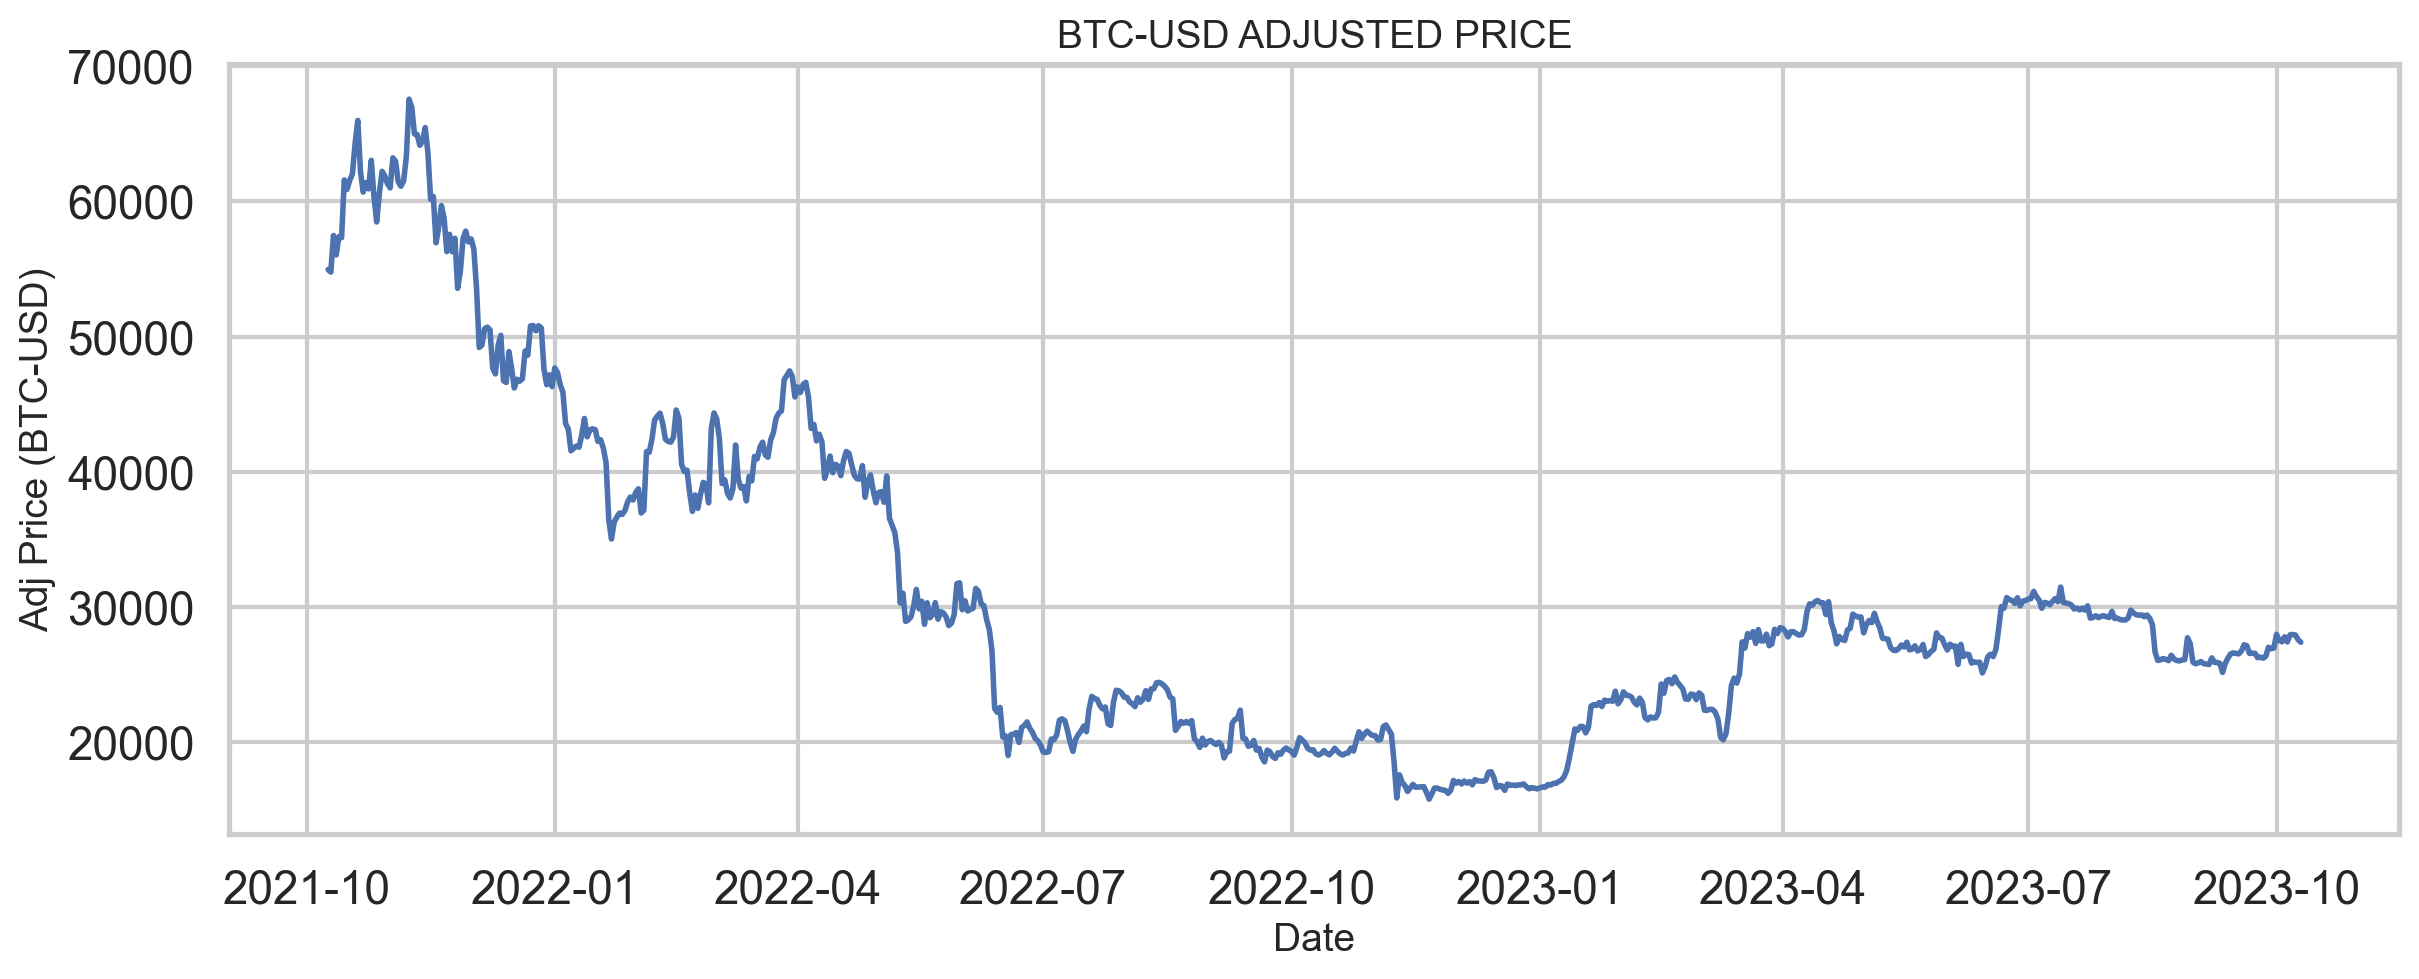

In [30]:
plt.figure(figsize=(14,5))
plt.plot(df['Adj Close'], lw=2)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Adj Price (BTC-USD)", fontsize=14)
plt.title("BTC-USD ADJUSTED PRICE", fontsize=14)

In [31]:
#Create the "L14" column in the DataFrame
df['L14'] = df['Low'].rolling(window=14).min()
#Create the "H14" column in the DataFrame
df['H14'] = df['High'].rolling(window=14).max()
#Create the "%K" column in the DataFrame
df['%K'] = 100*((df['Adj Close'] - df['L14']) / (df['H14'] - df['L14']) )
#Create the "%D" column in the DataFrame
df['%D'] = df['%K'].rolling(window=3).mean()

Text(0.5, 1.0, 'Oscillator')

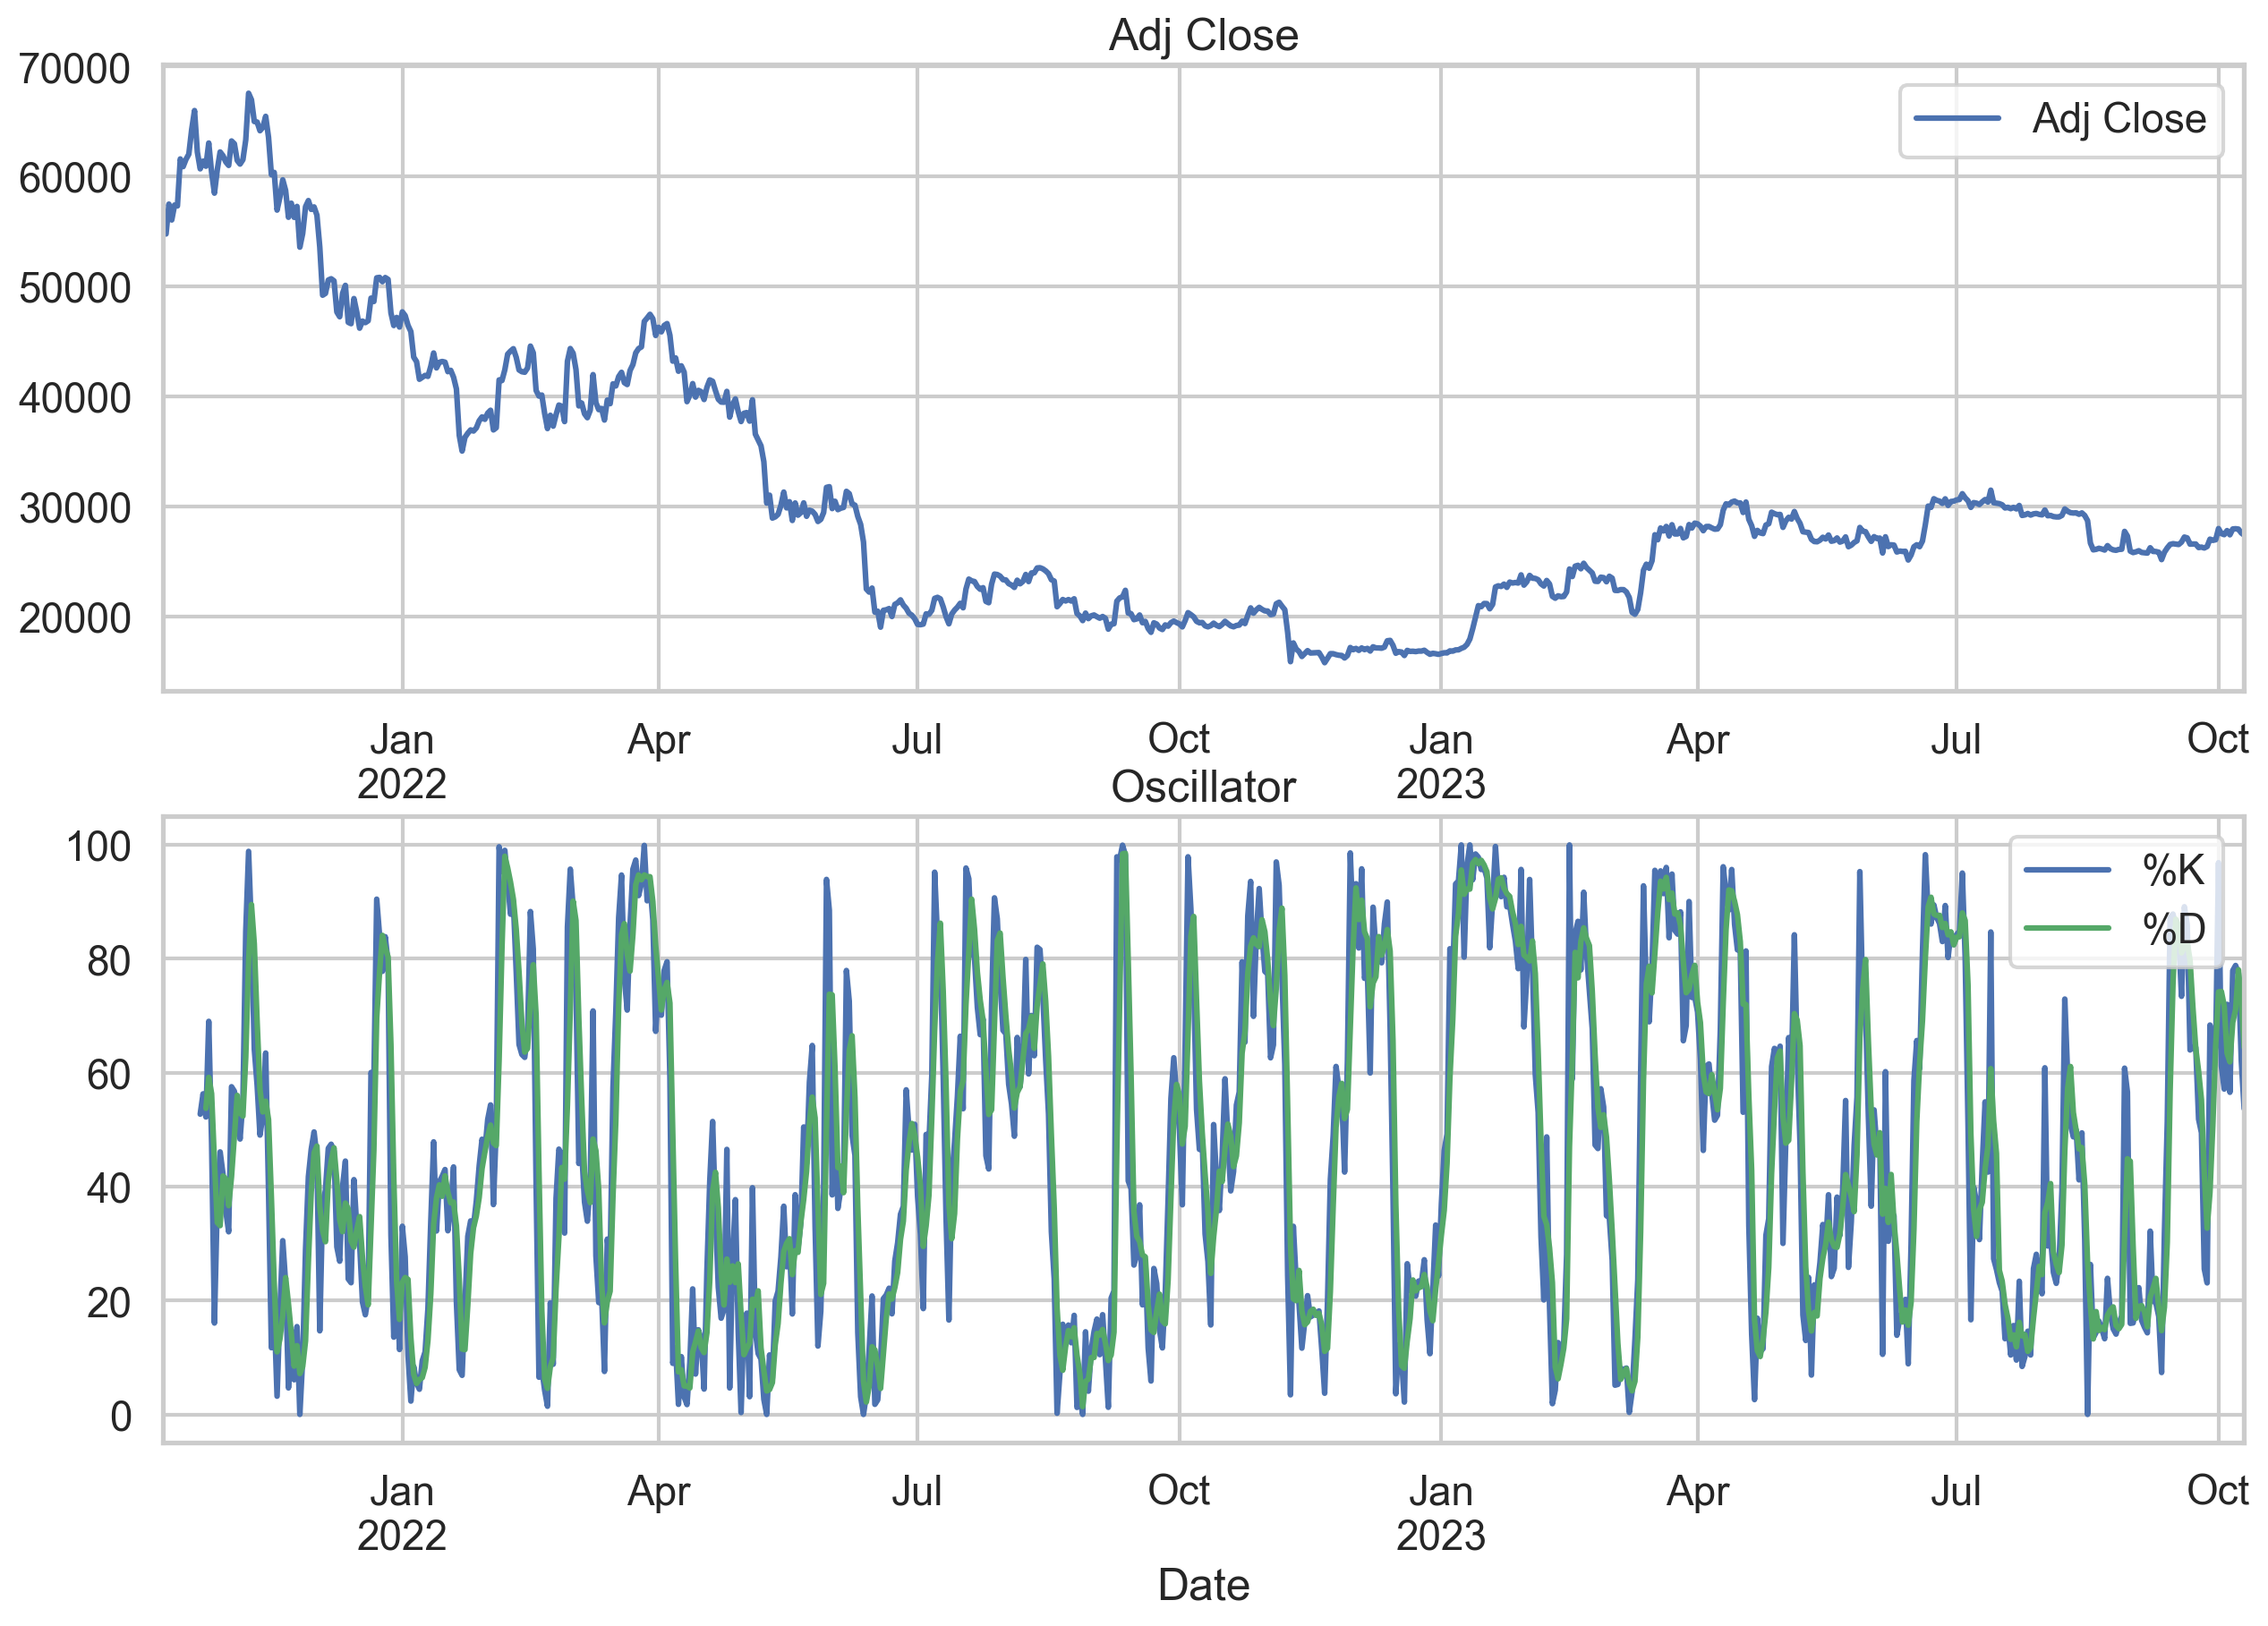

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(15,10))
df[['Adj Close']].plot(ax=axes[0]); axes[0].set_title('Adj Close')
df[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('Oscillator')

In [33]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
df['Sell Entry'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > 80) 
#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
df['Sell Exit'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) 
#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
df['Short'] = np.nan 
df.loc[df['Sell Entry'],'Short'] = -1 
df.loc[df['Sell Exit'],'Short'] = 0 
#Set initial position on day 1 to flat 
df['Short'][0] = 0 
#Forward fill the position column to represent the holding of positions through time 
df['Short'] = df['Short'].fillna(method='pad') 
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
df['Buy Entry'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < 20) 
#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
df['Buy Exit'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) 
#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
df['Long'] = np.nan  
df.loc[df['Buy Entry'],'Long'] = 1  
df.loc[df['Buy Exit'],'Long'] = 0  
#Set initial position on day 1 to flat 
df['Long'][0] = 0  
#Forward fill the position column to represent the holding of positions through time 
df['Long'] = df['Long'].fillna(method='pad') 
#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
df['Position'] = df['Long'] + df['Short']

<Axes: xlabel='Date'>

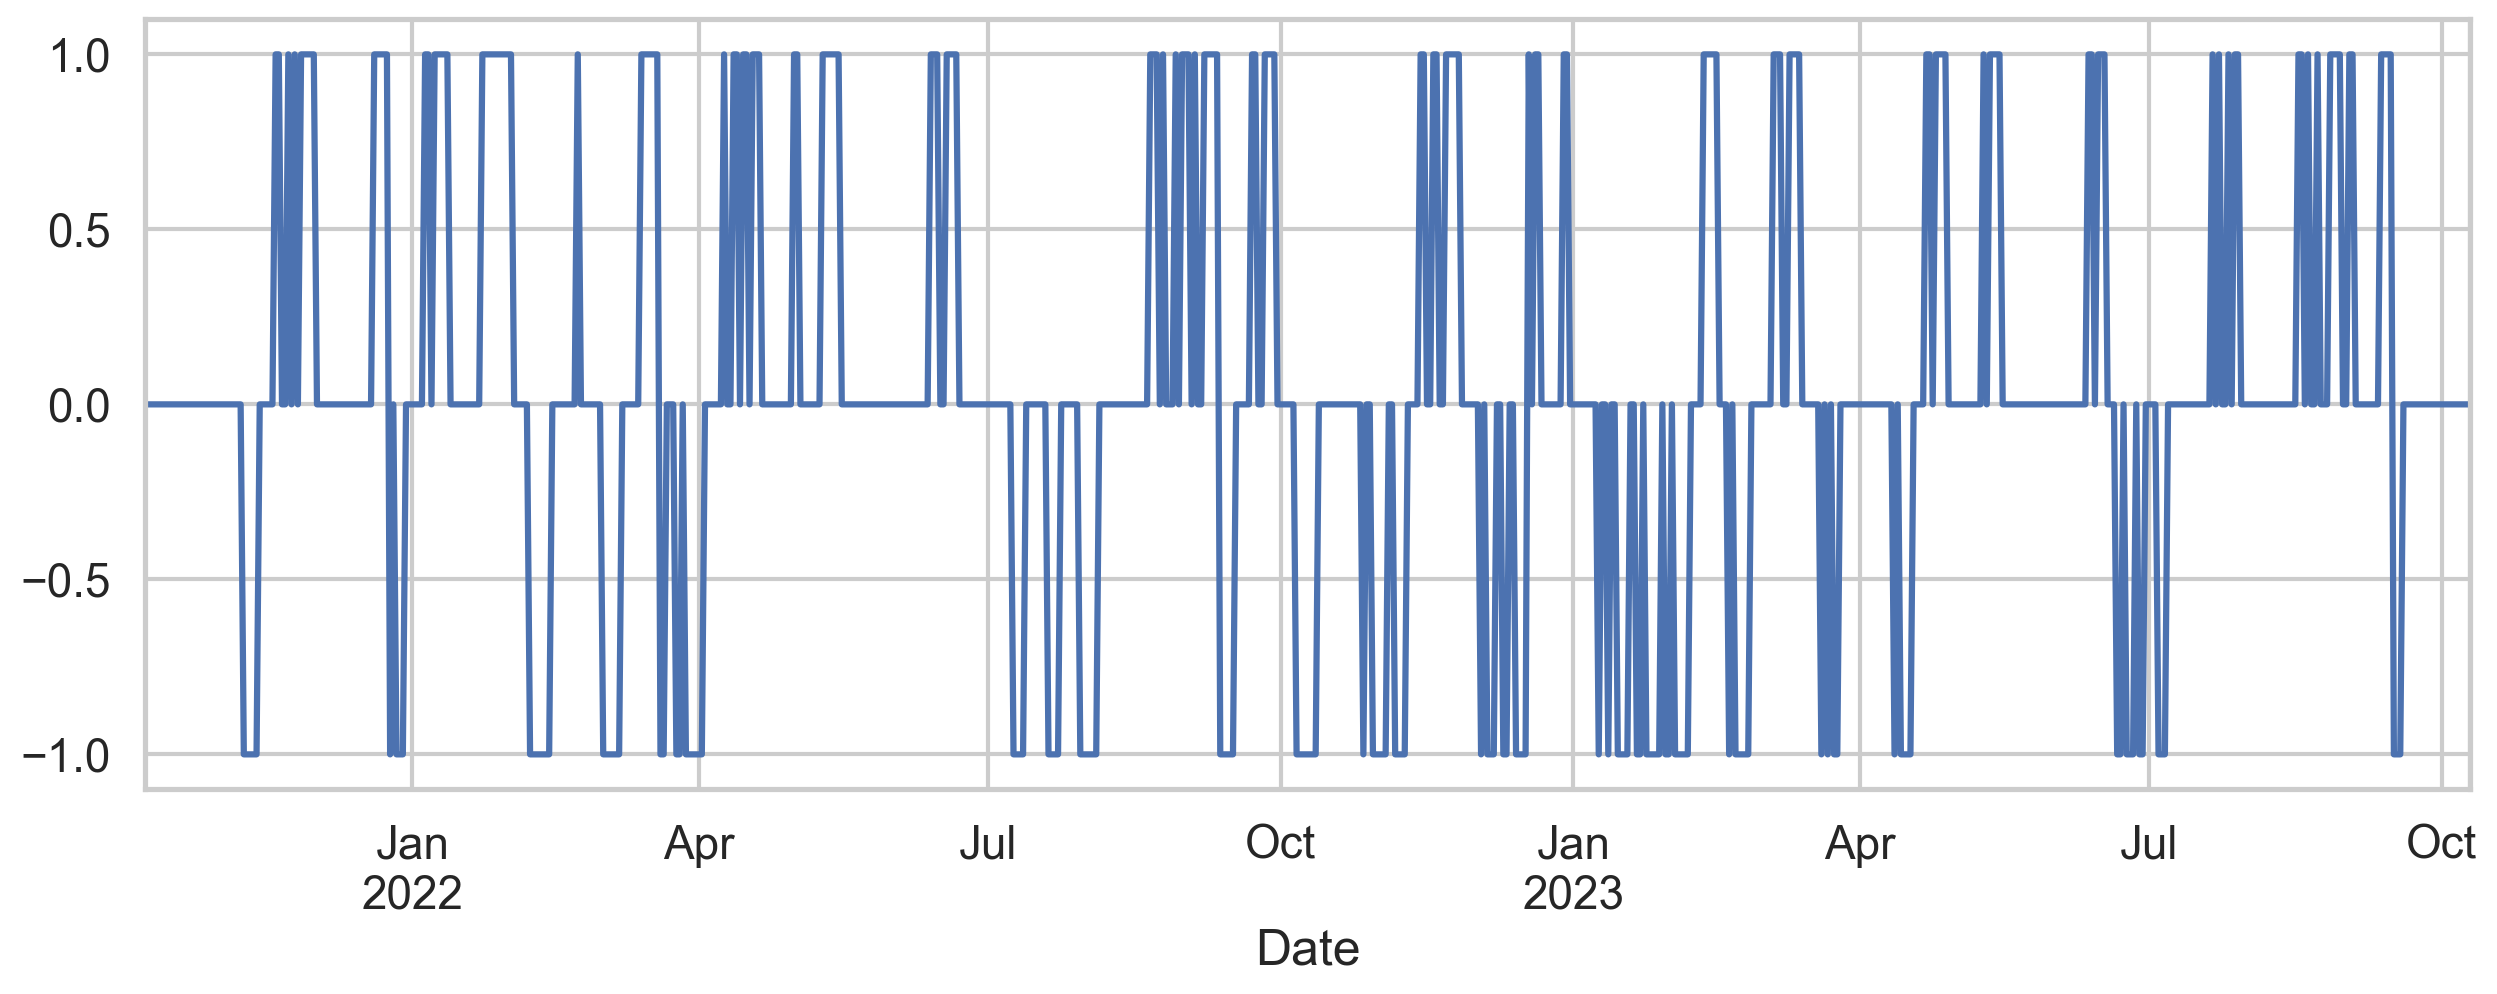

In [34]:
df['Position'].plot(figsize=(15,5))

<Axes: xlabel='Date'>

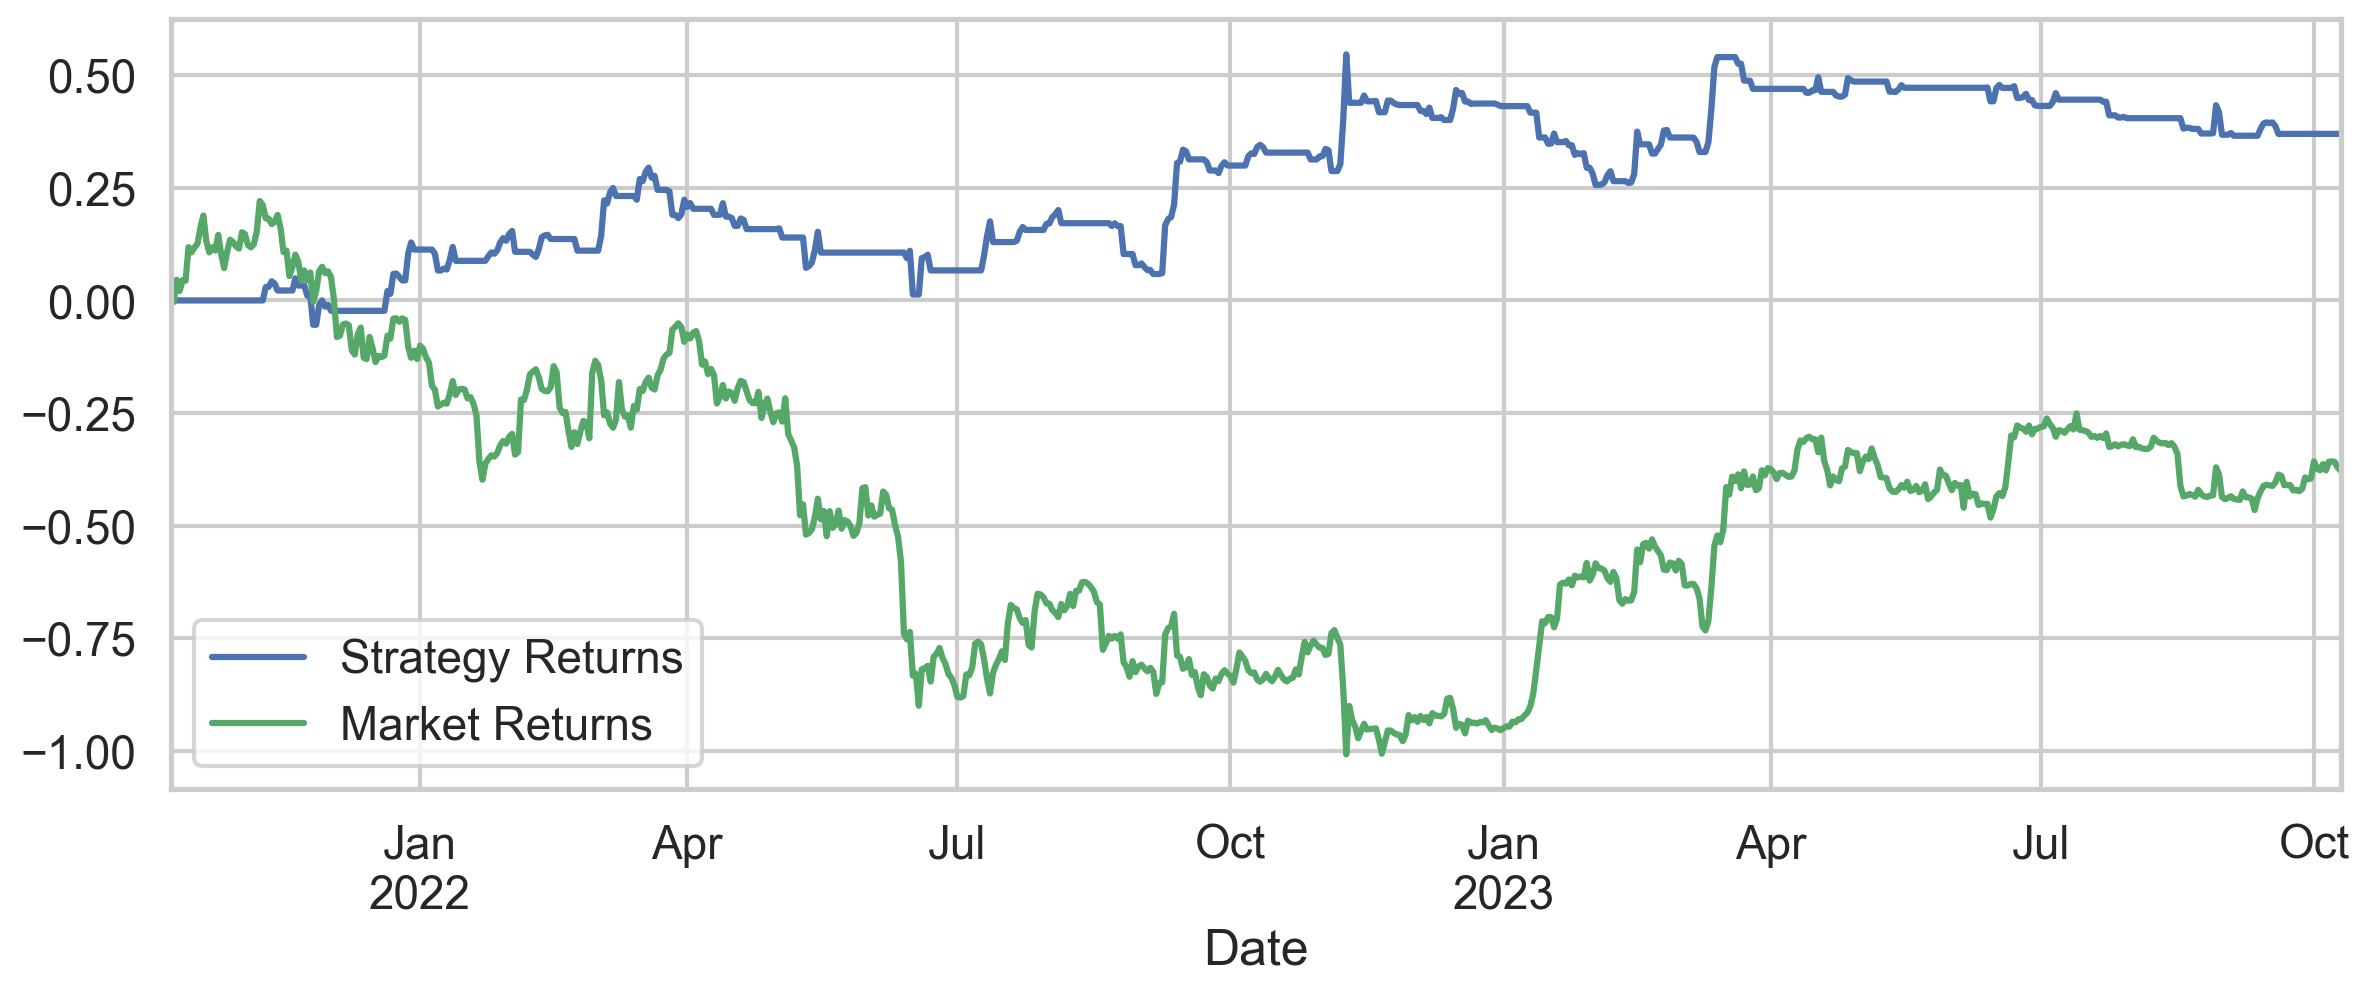

In [35]:
#Set up a column holding the daily Apple returns
df['Market Returns'] = df['Close'].pct_change()
#Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
#of business the previous day
df['Strategy Returns'] = df['Market Returns'] * df['Position'].shift(1)
#Finally plot the strategy returns versus Apple returns
df[['Strategy Returns','Market Returns']].cumsum().plot()

In [36]:
ticker=['BTC-USD']
start = dt.datetime(2021,10,9)
end = dt.datetime.now()
df=yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

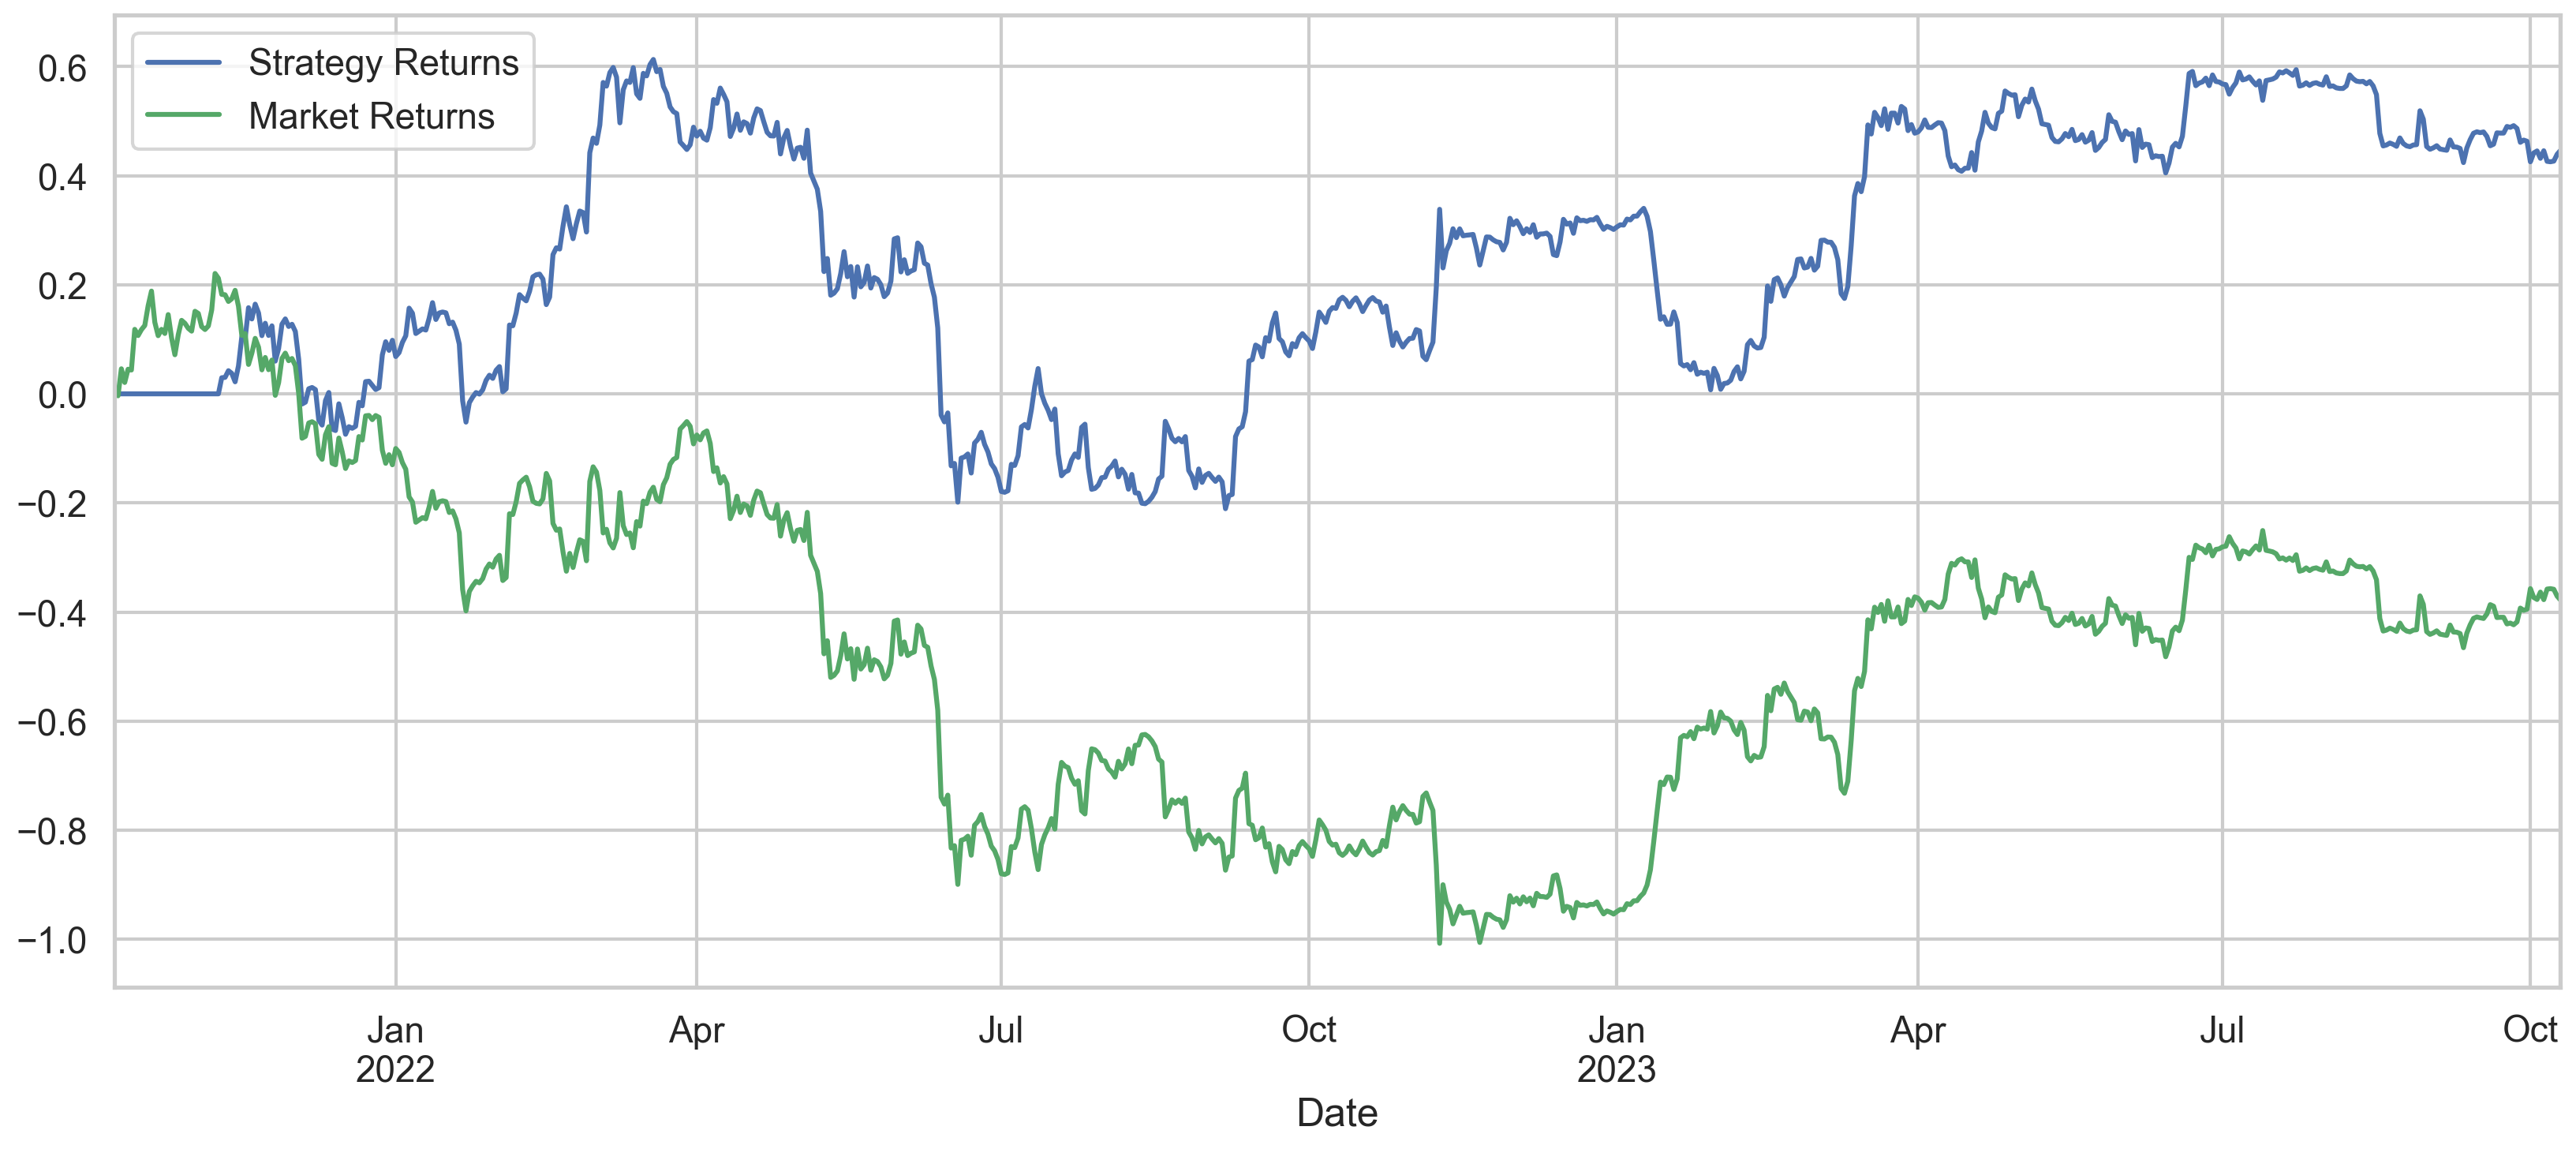

In [37]:
df['L14'] = df['Low'].rolling(window=14).min()
df['H14'] = df['High'].rolling(window=14).max()
df['%K'] = 100*((df['Close'] - df['L14']) / (df['H14'] - df['L14']) )
df['%D'] = df['%K'].rolling(window=3).mean()
df['Sell Entry'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > 80)
df['Buy Entry'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < 20)
#Create empty "Position" column
df['Position'] = np.nan 
#Set position to -1 for sell signals
df.loc[df['Sell Entry'],'Position'] = -1 
#Set position to -1 for buy signals
df.loc[df['Buy Entry'],'Position'] = 1 
#Set starting position to flat (i.e. 0)
df['Position'].iloc[0] = 0 
#Forward fill the position column to show holding of positions through time
df['Position'] = df['Position'].fillna(method='ffill')
#Set up a column holding the daily Apple returns
df['Market Returns'] = df['Close'].pct_change()
#Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
#of business the previous day
df['Strategy Returns'] = df['Market Returns'] * df['Position'].shift(1)
#Finally plot the strategy returns versus Apple returns
df[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,8))